In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

import os

from rolf.io import CreateTorchDataset, ReadHDF5
from rolf.tools.toml_reader import ReadConfig
from rolf.training.training import TrainModule, train_model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
config = ReadConfig("../configs/resnet16.toml")
train_config = config.training()

In [4]:
train_config

{'paths': {'data': PosixPath('../data/galaxy_data/all'),
  'model': PosixPath('../build/checkpoints')},
 'model_name': 'ResNet',
 'net_hyperparams': {'num_classes': 4,
  'hidden_channels': [16, 32, 64, 128],
  'block_groups': [4, 4, 4, 4],
  'block_name': 'ResBlock',
  'activation_name': 'mish'},
 'optimizer': 'SGD',
 'opt_hyperparams': {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001},
 'save_name': 'ResNet16',
 'batch_size': 30,
 'epochs': 20}

In [5]:
data = ReadHDF5("../data/galaxy_data_h5.h5")
data.make_transformer()

Output()

In [6]:
train_loader, val_loader, test_loader = data.create_data_loaders(
    batch_size=train_config["batch_size"], img_dir=train_config["paths"]["data"]
)

In [7]:
model, result, trainer = train_model(
    train_config["model_name"],
    train_loader,
    val_loader,
    test_loader,
    checkpoint_path=train_config["paths"]["model"],
    epochs=train_config["epochs"],
    save_name=train_config["save_name"],
    model_hparams=train_config["net_hyperparams"],
    optimizer_name=train_config["optimizer"],
    optimizer_hparams=train_config["opt_hyperparams"],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name        | Type             | Params | Mode  | In sizes         | Out sizes
----------------------------------------------------------------------------------------
0 | model       | ResNet           | 1.5 M  | train | [1, 1, 300, 300] | [1, 4]   
1 | loss_module | CrossEntropyLoss | 0      | train | ?                | ?        
----------------------------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.942     Total estimated model params size (MB)


Sanity Checking: |                                                       | 0/? [00:00<?, ?it/s]

Training: |                                                              | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                            | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
/scratch/carauner/envs/radio_ml/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Testing: |                                                               | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: |                                                               | 0/? [00:00<?, ?it/s]

In [8]:
result

{'test': 0.5349999666213989, 'val': 0.5299999713897705}

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test_img = list(iter(test_loader))

In [18]:
pred = [model(test_img[i][0]) for i in range(len(test_img))]

In [11]:
with torch.no_grad():
    preds = np.argmax(pred.to("cpu"), axis=1)

In [26]:
liste = [test_img[i][1] == preds[i] for i in range(len(test_img))]

In [32]:
liste[0].shape[0]

30

In [39]:
liste[0].sum()

tensor(10)

In [45]:
sums, lens = [], []
for i in range(len(liste)):
    sums.append(liste[i].sum())
    lens.append(liste[i].shape[0])

In [47]:
np.sum(sums) / np.sum(lens)

0.36

In [13]:
test_img[0]

[tensor([[[[-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           ...,
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354]]],
 
 
         [[[-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           ...,
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
           [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354]]],
 
 
         [[[-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
       

In [14]:
for im in test_img[0][0][:2]:
    print(im.squeeze())

tensor([[-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        ...,
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354]])
tensor([[-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        ...,
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354],
        [-0.0354, -0.0354, -0.0354,  ..., -0.0354, -0.0354, -0.0354]])


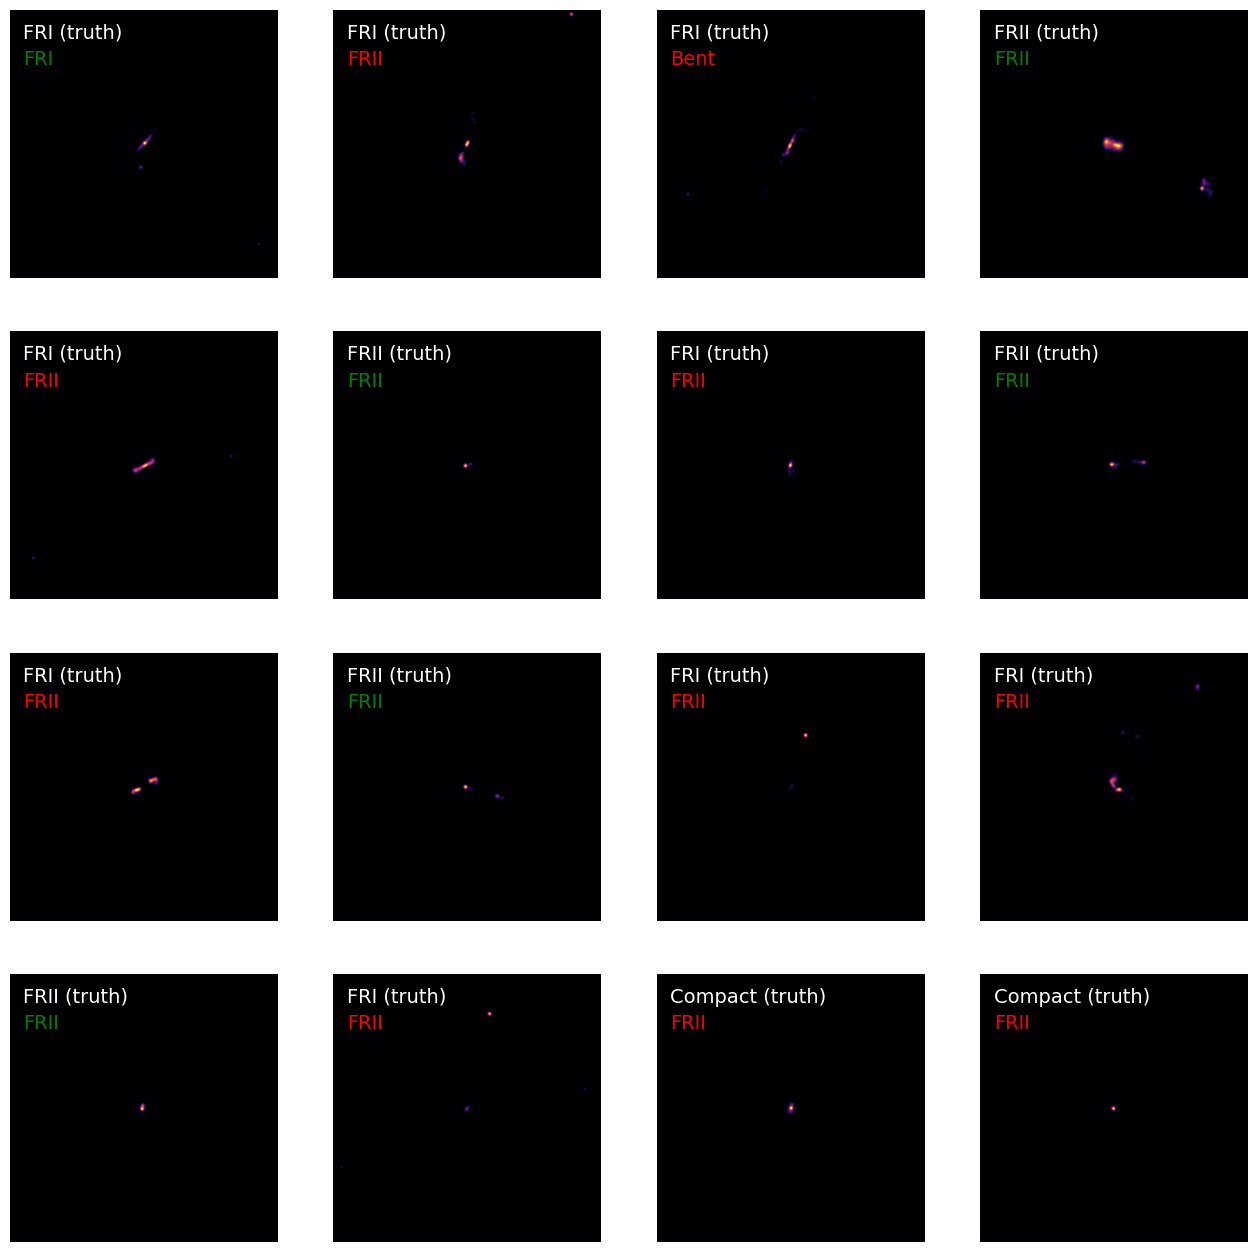

In [15]:
labels_map = {
    0: "FRI",
    1: "FRII",
    2: "Compact",
    3: "Bent",
}

if len(test_img[0]) > 16:
    images = test_img[0][0][:16]
    labels = test_img[0][1][:16]
    labels_pred = preds[:16]
else:
    images = test_img[0][0]
    labels = test_img[0][1]
    labels_pred = preds

figure, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()

for ax, img, label, label_pred in zip(axs, images, labels, labels_pred):
    img = img.squeeze()
    label = label.item()
    label_pred = label_pred.item()

    correct = label_pred == label

    ax.text(
        0.05,
        0.95,
        f"{labels_map[label]} (truth)",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        color="white",
        fontsize=14,
    )
    ax.text(
        0.05,
        0.85,
        labels_map[label_pred],
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        color="green" if correct else "red",
        fontsize=14,
    )
    ax.axis("off")
    ax.imshow(img, cmap="inferno")

plt.show()